# Прогнозирование уровня удовлетворённости сотрудников и их оттока 

Компания **«Работа с заботой»** стремится минимизировать финансовые риски и снизить отток сотрудников. Для этого были предоставлены данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Необходимо помочь бизнесу:  
1. **Предсказать уровень удовлетворённости работой**
2. **Прогнозировать риск увольнения**



### Описание данных
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [39]:
import os
import phik
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler

warnings.filterwarnings("ignore")
RANDOM_STATE = 42

### Загрузка данных

In [5]:
# функция проверки наличия датасета
def get_dataset(path_1, path_2, sep=','): 
    if os.path.exists(path_1):
        return parse_dataset(path_1, sep)
    elif os.path.exists(path_2):
        return parse_dataset(path_2, sep)
    else:
        print('Произошла ошибка')


# функция для парсинга таблицы с отображением ее свойств
def parse_dataset(path, sep):
    df = pd.read_csv(path, sep=sep)
    display(df.head())
    display((df.isna().mean()).sort_values(ascending=False).to_frame(name='Процент пропусков'))
    df.info()
    
    return df

In [6]:
# функция отображения уникальных значений качественных признаков
def unique_category(df):
    for clmn in df.select_dtypes(exclude='number'):
        if df[clmn].nunique() <= 20:
            print(clmn+":", df[clmn].unique(), end='\n\n')

In [7]:
path_1 = '/datasets/train_job_satisfaction_rate.csv'
path_2 = './datasets/train_job_satisfaction_rate.csv'

train_job_satisfaction = get_dataset(path_1, path_2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,Процент пропусков
dept,0.0015
level,0.0010
id,0.0000
workload,0.0000
employment_years,0.0000
last_year_promo,0.0000
last_year_violations,0.0000
supervisor_evaluation,0.0000
salary,0.0000
job_satisfaction_rate,0.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [8]:
unique_category(train_job_satisfaction)

dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

level: ['junior' 'middle' 'sinior' nan]

workload: ['medium' 'high' 'low']

last_year_promo: ['no' 'yes']

last_year_violations: ['no' 'yes']



В таблице **`train_job_satisfaction`** присутствуют пропуски в признаках `dept` и `level`. \
`last_year_promo`, `last_year_violations` - бинарные признаки

In [9]:
path_1 = '/datasets/test_features.csv'
path_2 = './datasets/test_features.csv'

test_features = get_dataset(path_1, path_2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,Процент пропусков
dept,0.0010
level,0.0005
id,0.0000
workload,0.0000
employment_years,0.0000
last_year_promo,0.0000
last_year_violations,0.0000
supervisor_evaluation,0.0000
salary,0.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


В таблице **`test_features`**, как и в **`train_job_satisfaction`** присутствуют пропуски в столбцах `dept` и `level`.

### Предобработка данных

#### Поиск дубликатов

In [10]:
print('количество дубликатов в таблице train_job_satisfaction:', train_job_satisfaction.duplicated(subset='id').sum())
print('количество дубликатов в таблице test_features:', test_features.duplicated(subset='id').sum())

количество дубликатов в таблице train_job_satisfaction: 0
количество дубликатов в таблице test_features: 0


Все сотрудники в таблицах уникальны, дубликатов не обнаружено.

#### Замена пропусков

In [11]:
numeric_features = train_job_satisfaction.select_dtypes(include='number').columns[1:-1] # без id и target
categorical_features = train_job_satisfaction.select_dtypes(exclude='number').columns
lst_binary_feature = ['last_year_promo', 'last_year_violations']

In [12]:
fill_na_num = Pipeline([
    ('simple_imputer_num',
    SimpleImputer(missing_values=np.nan, strategy='median'))]
)

fill_na_cat = Pipeline([
    ('simple_imputer_cat',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]
)

binary_feature = Pipeline([
    ('ord',
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, \
                   categories=[['no', 'yes'], ['no', 'yes']])),

    ('simple_imputer_after_ord',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]
)


In [13]:
preliminary_preprocessor = ColumnTransformer(
    [
        ('fill_na_num', fill_na_num, numeric_features),
        ('fill_na_cat', fill_na_cat, categorical_features),
        ('binary_feature', binary_feature, lst_binary_feature)
    ], 
    remainder='passthrough'
)

Пайплайн для замены пропусков (на чаще всего встречаемые значения в признаках) и  кодировки бинарных признаков `last_year_promo`, `last_year_violations`.

##### Тренировочный датасет

In [14]:
lst_tjs_na =  train_job_satisfaction.query('dept.isna() or level.isna()')['id'].to_list()
train_job_satisfaction.query('id in @lst_tjs_na')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [15]:
preliminary_preprocessor.fit(train_job_satisfaction)

# Список столбцов для новой таблицы
lst_name_feature = [s.replace('remainder__', '').replace('fill_na_', '').replace('num__', '').replace('cat__', '') \
                 for s in preliminary_preprocessor.get_feature_names_out()]

# Порядок столбцов прошлой таблицы
lst_columns_train = ['binary_feature__'+clm if clm in ['last_year_promo', 'last_year_violations'] else clm \
                 for clm in train_job_satisfaction.columns.tolist()]

In [16]:
preprocessor_train_job_satisfaction = pd.DataFrame(data=preliminary_preprocessor.transform(train_job_satisfaction), \
                                                   columns=lst_name_feature)[lst_columns_train]

preprocessor_train_job_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   id                                    4000 non-null   object
 1   dept                                  4000 non-null   object
 2   level                                 4000 non-null   object
 3   workload                              4000 non-null   object
 4   employment_years                      4000 non-null   object
 5   binary_feature__last_year_promo       4000 non-null   object
 6   binary_feature__last_year_violations  4000 non-null   object
 7   supervisor_evaluation                 4000 non-null   object
 8   salary                                4000 non-null   object
 9   job_satisfaction_rate                 4000 non-null   object
dtypes: object(10)
memory usage: 312.6+ KB


Пропуски в столбцах `dept`, `level` таблицы **`train_job_satisfaction`** были заменены на значения моды. \
Типы данных столбцов стали object, для бинарных признаков изменились названия.

In [17]:
train_job_satisfaction = (preprocessor_train_job_satisfaction
                            .rename(columns=lambda x: x.replace('binary_feature__', ''))
                            .convert_dtypes(convert_string=False))

display(train_job_satisfaction.query('id in @lst_tjs_na'))
train_job_satisfaction.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,junior,medium,1,0,0,4,27600,0.66
1469,416327,sales,junior,low,1,0,0,5,18000,0.73
1526,694746,sales,junior,medium,5,0,0,4,21600,0.62
1630,814624,sales,junior,medium,3,0,0,4,24000,0.88
1633,475114,sales,junior,high,4,0,0,4,31200,0.63
1745,135043,sales,junior,medium,1,0,0,3,26400,0.3
2522,998838,sales,junior,medium,1,0,0,5,27600,0.71
2781,497243,sales,junior,medium,1,0,0,3,26400,0.28
2975,168668,sales,junior,low,3,0,0,4,18000,0.88
3866,641150,sales,junior,low,3,0,1,4,12000,0.54


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   Int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   Int64  
 5   last_year_promo        4000 non-null   Int64  
 6   last_year_violations   4000 non-null   Int64  
 7   supervisor_evaluation  4000 non-null   Int64  
 8   salary                 4000 non-null   Int64  
 9   job_satisfaction_rate  4000 non-null   Float64
dtypes: Float64(1), Int64(6), object(3)
memory usage: 340.0+ KB


Значения столбцов таблицы **`train_job_satisfaction`** преобразованы к соответсвующим типам данных, названия бинарных признаков были изменены на исходные. 

##### Тестовый датасет

In [18]:
lst_tf_na =  test_features.query('dept.isna() or level.isna()')['id'].to_list()
test_features.query('id in @lst_tf_na')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [19]:
preprocessor_test_features = pd.DataFrame(data=preliminary_preprocessor.fit_transform(test_features), \
                                           columns=lst_name_feature[:-1])[lst_columns_train[:-1]]

preprocessor_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   id                                    2000 non-null   object
 1   dept                                  2000 non-null   object
 2   level                                 2000 non-null   object
 3   workload                              2000 non-null   object
 4   employment_years                      2000 non-null   object
 5   binary_feature__last_year_promo       2000 non-null   object
 6   binary_feature__last_year_violations  2000 non-null   object
 7   supervisor_evaluation                 2000 non-null   object
 8   salary                                2000 non-null   object
dtypes: object(9)
memory usage: 140.8+ KB


Пропуски в столбцах `dept`, `level` таблицы **`test_features`** были заменены на значения моды. \
Типы данных столбцов стали object, для бинарных признаков изменились названия.

In [20]:
test_features = (preprocessor_test_features
                            .rename(columns=lambda x: x.replace('binary_feature__', ''))
                            .convert_dtypes(convert_string=False))

display(test_features.query('id in @lst_tf_na'))
test_features.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,sales,junior,medium,1,0,0,1,20400
312,471990,sales,junior,low,1,0,0,3,12000
1196,832342,sales,junior,medium,1,0,0,4,28800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   Int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   Int64 
 5   last_year_promo        2000 non-null   Int64 
 6   last_year_violations   2000 non-null   Int64 
 7   supervisor_evaluation  2000 non-null   Int64 
 8   salary                 2000 non-null   Int64 
dtypes: Int64(6), object(3)
memory usage: 152.5+ KB


Значения столбцов таблицы **`test_features`** преобразованы к соответсвующим типам данных, названия бинарных признаков были изменены на исходные. 

#### Вывод предобработки данных

1. Дубликаты отсутствуют
2. Пропуски категориальных признаков были заменены, ипользуя пайплайн, на значения моды
3. Названия столбцов и их типы преобразованы к исходным

### Исследовательский анализ данных

In [24]:
# Функция для отображения гистограммы всех признаков
def plt_hist(df):
    plt.figure(figsize=(18, 10))
    i = 1
    num_columns = df.select_dtypes(include='number').columns[1:]
    cat_columns = train_job_satisfaction.select_dtypes(exclude='number').columns
    
    # числовые 
    for clm_n in num_columns:
        plt.subplot(3, 3, i)
        if df[clm_n].nunique() <= 20:
            axes = sns.countplot(data=df.iloc[:, 1:], x=clm_n, color='#1F77B4') 
        else:
            axes = sns.histplot(data=df.iloc[:, 1:], x=clm_n)
        axes.set_ylabel('количество')
        i += 1

    # категориальные
    for clm_c in cat_columns:
        plt.subplot(3, 3, i)
        axes = sns.countplot(data=train_job_satisfaction, x=clm_c, color='#1F77B4')
        axes.set_ylabel('количество')
        i += 1
        
    plt.show()

#### Тренировочный датасет

In [22]:
train_job_satisfaction.iloc[:, 1:].describe()

,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,0.030000,0.139750,3.476500,33926.700000,0.533995
std,2.542513,0.170609,0.346771,1.008812,14900.703838,0.225327
min,1.000000,0.000000,0.000000,1.000000,12000.000000,0.030000
25%,2.000000,0.000000,0.000000,3.000000,22800.000000,0.360000
50%,3.000000,0.000000,0.000000,4.000000,30000.000000,0.560000
75%,6.000000,0.000000,0.000000,4.000000,43200.000000,0.710000
max,10.000000,1.000000,1.000000,5.000000,98400.000000,1.000000


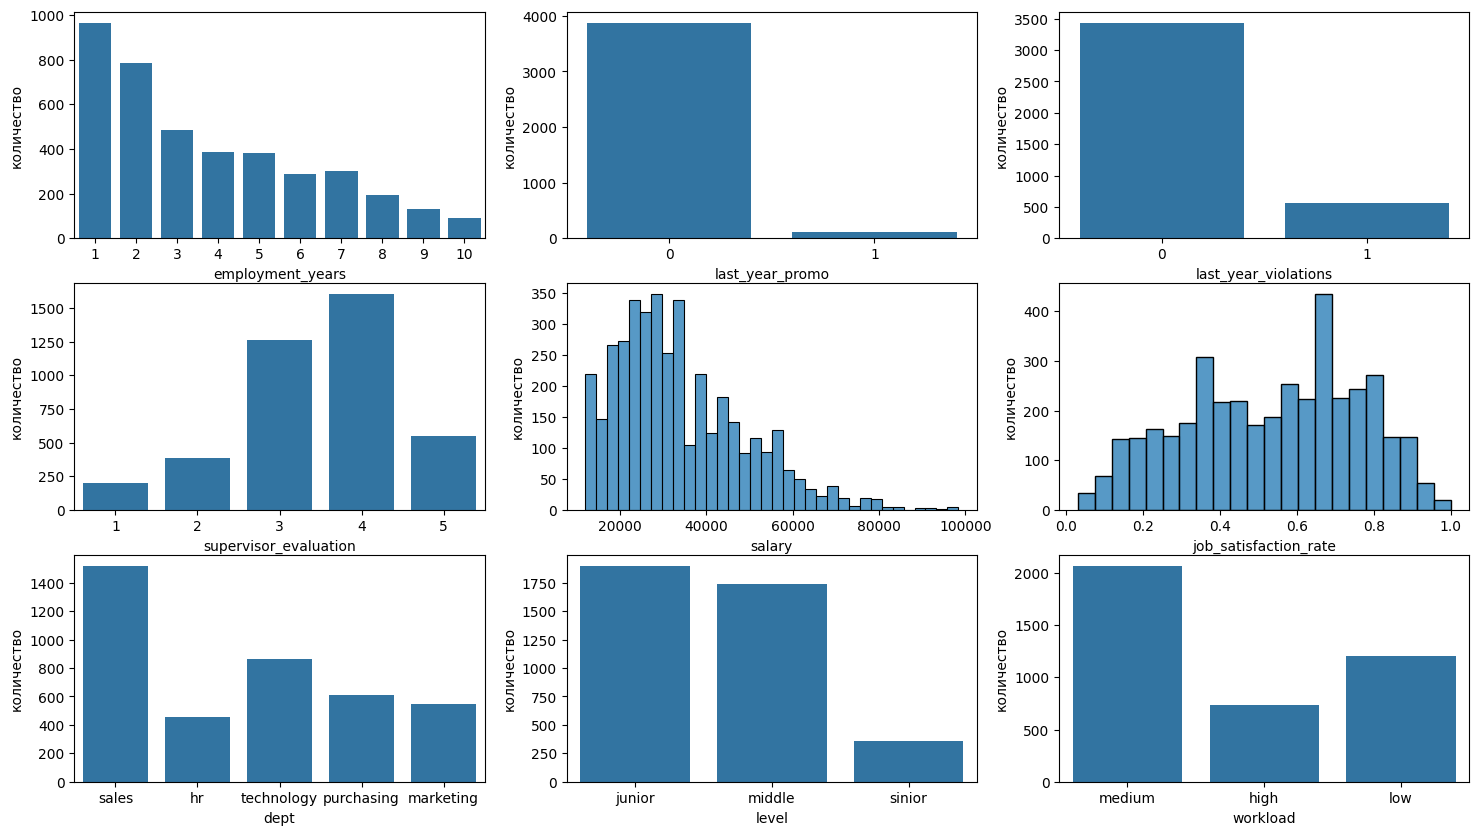

In [25]:
plt_hist(train_job_satisfaction)

За последний год в компании у 120 (3%) сотрудников было повышение, 559 (14%) сотрудников нарушали трудовой договор. \
Чаще всего сотрудники имеют уровни занимаемой должности 'junior' - 47% и 'middle' - 44% и имеют среднюю загруженность - в 52% наблюдений. \
75% сотрудников работают в компании менее 6 лет. \
113 сотрудников имеют минимальную зароботную плату - 12000. \
Отдел 'sales' имеет наибольшее количество сотрудников - 1518. 

#### Тестовый датасет

In [26]:
test_features.describe()

,id,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,0.031500,0.131000,3.526500,34066.800000
std,253851.326129,2.537222,0.174708,0.337485,0.996892,15398.436729
min,100298.000000,1.000000,0.000000,0.000000,1.000000,12000.000000
25%,339052.000000,1.000000,0.000000,0.000000,3.000000,22800.000000
50%,550793.000000,3.000000,0.000000,0.000000,4.000000,30000.000000
75%,765763.750000,6.000000,0.000000,0.000000,4.000000,43200.000000
max,999029.000000,10.000000,1.000000,1.000000,5.000000,96000.000000


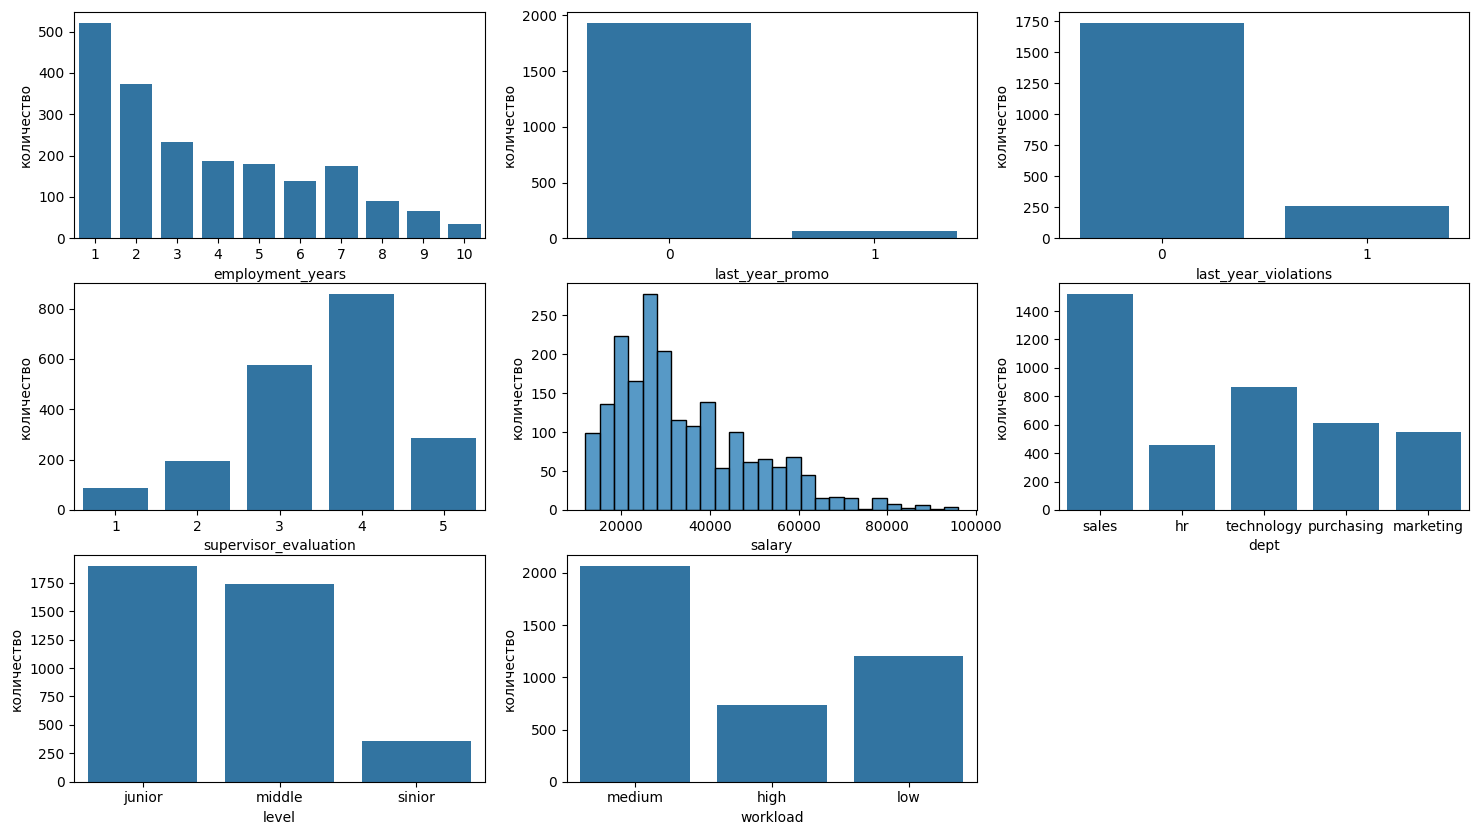

In [27]:
plt_hist(test_features)

In [37]:
print('Количество тестовых данных в тренировочных:', \
      len(train_job_satisfaction.query(f'id in {test_features["id"].tolist()}')))

Количество тестовых данных в тренировочных: 0


Статистически тестовые данные имеют очень близкие распределения к тренировочным. Следовательно тренировочные данные будут релевантными для обучения моделей. Утечки в данных нет.

#### Корреляционный анализ

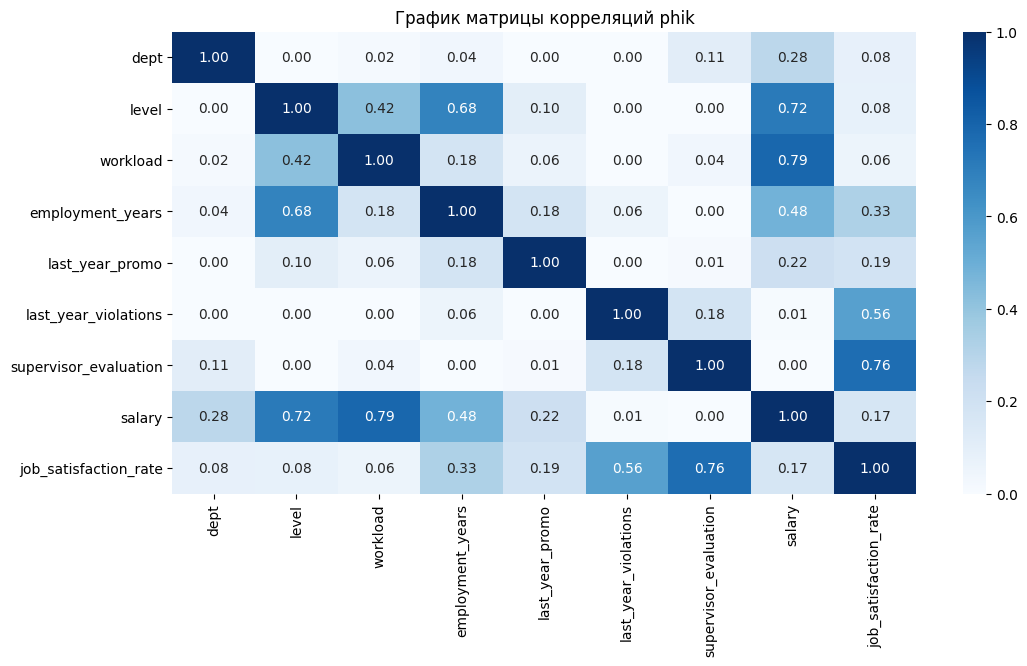

In [49]:
plt.figure(figsize=(12, 6))
plt.title('График матрицы корреляций phik')
sns.heatmap(train_job_satisfaction.iloc[:, 1:].phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']),
            annot=True,
            fmt='.2f',
            cmap='Blues');

1. Мультиколлениарность
    1. Высокая:
        - `workload` и `salary` - 0.79
        - `level` и `salary` - 0.72
    2. Заметная:
        - `level` и `employment_years` - 0.68
    3. Умеренная:
        - `employment_years` и `salary` - 0.48
        - `level` и `workload` - 0.42


2. Корреляция с целевым
    - `supervisor_evaluation` - 0.76
    - `last_year_violations` - 0.56
    - `employment_years` - 0.33


Оценка руководителя тесно связана с удовлетворенностью сотрудника. Можно добавить в форму опроса сотрудников оценку их отношений с руководителем. Возможно, это даст лучшее понимание связи признаков.

#### Вывод исследовательского анализа

1. Порядковые категориальные:
    - `employment_years`
    - `last_year_promo`
    - `last_year_violations`
    - `supervisor_evaluation`
    - `level`
    - `workload`

2. Количественные непрерывные:
    - `salary`

3. Номинальные категориальные:
    - `dept`

Для линейных моделей важны упорядоченные и неупорядоченные признаки, поэтому необходимо использовать правильную технику кодирования, чтобы не создавать линейные зависимости там, где их нет \
Упорядоченные данные стоит подготавливать с помощью OrdinalEncoder с указанием ранга \
Неупорядоченные стоит подготавливать с помощью OneHotEncoder